## Predicting house prices using k-nearest neighbors regression

### Fire up GraphLab Create

In [187]:
import graphlab

### Load in house sales data

In [188]:
sales = graphlab.SFrame('kc_house_data_small.gl/')

### Explore the house sales data

In [189]:
sales[0:1]

Columns:
	id	str
	date	datetime
	price	int
	bedrooms	float
	bathrooms	float
	sqft_living	float
	sqft_lot	int
	floors	float
	waterfront	int
	view	int
	condition	int
	grade	int
	sqft_above	int
	sqft_basement	int
	yr_built	int
	yr_renovated	int
	zipcode	str
	lat	float
	long	float
	sqft_living15	float
	sqft_lot15	float

Rows: 1

Data:
+------------+---------------------------+--------+----------+-----------+
|     id     |            date           | price  | bedrooms | bathrooms |
+------------+---------------------------+--------+----------+-----------+
| 7129300520 | 2014-10-13 00:00:00+00:00 | 221900 |   3.0    |    1.0    |
+------------+---------------------------+--------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    1180.0   |   5650   |  1.0   |     0      |  0   |     3     |   7   |    1180    |
+-------------+----------+--------+------------+------+-----------+-------+------------+
+---------------+----------+--------------+---------+-------------+
| sqft_basement | yr_built | yr_renovated | zipcode |     lat     |
+---------------+----------+--------------+---------+-------------+
|       0       |   1955   |      0       |  98178  | 47.51123398 |
+---------------+----------+--------------+---------+-------------+
+---------------+---------------+-----+
|      long     | sqft_living15 | ... |
+---------------+---------------+-----+
| -122.25677536 |     1340.0    | ... |
+---------------+---------------+-----+
[1 rows x 21 columns]

### Import Numpy

In [190]:
import numpy as np

### Function to convert sframe to numpy matrix and array

In [191]:
def get_numpy_data(data_sframe, features, output):    
    data_sframe['constant'] = 1 # new constant column in the sframe signifying intercept
    
    features = ['constant'] + features # prepend constant to features list
    
    features_sframe = data_sframe[features] # new sframe selecting columns from data_sframe mentioned in features list

    feature_matrix = features_sframe.to_numpy() # convert sframe to numpy matrix

    output_sarray = data_sframe['price'] # an sarray consisting of the output column

    output_array = output_sarray.to_numpy() # converts sarray to a numpy array

    return(feature_matrix, output_array)

### Function to normalize features of the matrix

In [192]:
def normalize_features(features_matrix):
    norms = np.linalg.norm(features_matrix, axis=0)
    normalized_features = features_matrix / norms
    return(normalized_features, norms)

### Split data into training, test, and validation sets

In [193]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

### Feature list

In [194]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

### Convert sframe datasets into numpy matrix and output numpy array

In [195]:
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

The features in the test and validation sets must be divided by the same norms used to divide features of train set, so that the training, test, and validation sets are normalized consistently.

### Normalize features

In [196]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

## Compute a single distance

* Lets compute distance between house no.1 from test set and house no.10 from train set
* The features associated with both these houses seen in the 18-dimensional vector have values between 0 to 1

In [197]:
house_1 = features_test[0]
print house_1

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345386 -0.01346927  0.01375926  0.0016225 ]


In [198]:
house_2 = features_train[9]
print house_2

[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346254  0.01195898  0.00156612]


In [199]:
distance = np.sqrt(np.sum((house_1-house_2)**2))
print distance

0.0597235937167


## Compute multiple distances

To do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

### Function to calculate euclidean distance

In [200]:
def euclidean_distance(query_house, houses):
    distance_list = []
    for house in houses:
        distance = np.sqrt(np.sum((query_house-house)**2))
        distance_list.append(distance)
    return(distance_list)

* Lets compute distance for query house no.1 from test set against first 10 houses of the train set

In [201]:
distance_list = euclidean_distance(features_test[0], features_train[0:10])
print distance_list

[0.0602747091729555, 0.085468811488270832, 0.061499464371202843, 0.053402739788200579, 0.058444840639381393, 0.059879215101840008, 0.054631404972615261, 0.055431083241597921, 0.052383627840972731, 0.059723593716661257]


Among the first 10 training houses, the closest house to the test query house is:

In [222]:
distance, train_house_number = min((val, idx) for (idx, val) in enumerate(distance_list))
print "Train house number: " ,train_house_number
print "Distance of test query house: " ,distance

Train house number:  8
Distance of test query house:  0.052383627841


## Perform 1-nearest neighbor regression

Looping to calculate distance is not efficient in python so let us use two single line expressions instead of using the previously defined euclidean distance function to calculate distance of 1 test house from all train houses.

First step is to calculate the difference between the features of each training house and the query (test) house

In [203]:
diff = features_train[0:len(features_train)] - features_test[0]

Second step is to take these feature-by-feature differences in `diff`, square each, take their sum and finally perform square root

In [204]:
distances = np.sqrt(np.sum(diff**2, axis=1))

### Function that computes the distances from a query house to all training houses
We will use the previous two single line expressions and modify them so that they can be used in this function to calculate the distance

In [205]:
def compute_distances(features_instances, features_query):
    diff = features_instances[0:len(features_instances)] - features_query
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return(distances)

### Compute 1 nearest neighbor regression for a single query house

In [206]:
query_house = features_test[2]
distances = compute_distances(features_train, query_house)
print distances

[ 0.01954476  0.06861035  0.02165079 ...,  0.02433478  0.02622734
  0.02637942]


Closest house to the query house

In [223]:
distance, train_house_number = min((val, idx) for (idx, val) in enumerate(distances))
print "Train house number: " ,train_house_number
print "Distance of test query house: " ,distance

Train house number:  382
Distance of test query house:  0.00286049526751


### Predicted value of the query house

In [226]:
predicted_value = output_train[382]
print predicted_value

249000


## Perform k-nearest neighbor regression

### Function to calculate k-nearest neighbor of a single query house

In [227]:
def compute_k_distances(k, features_matrix, feature_vector):
    all_distances = compute_distances(features_matrix, feature_vector)
    house_numbers = np.argsort(all_distances) # sorts distances in ascending order and inserts their indexes in the array
    return house_numbers[0:k]

### Compute k-nearest neighbors of a single query house

In [228]:
query_house = features_test[2]
house_numbers = compute_k_distances(4, features_train, query_house)
print house_numbers # four closest houses from the training set to the house present in the test set

[ 382 1149 4087 3142]


## Make a single prediction by averaging k nearest neighbor outputs

### Function to predict price of a house using k-nearest neighbors

In [211]:
def predict_price(k, features_matrix, feature_vector, prices):
    all_distances = compute_distances(features_matrix, feature_vector)
    house_numbers = np.argsort(all_distances) # sorts distances in ascending order and inserts their indexes in the array
    k_house_numbers = house_numbers[0:k] # closest k houses to the query house
    total_price = 0
    for house_number in k_house_numbers:
        total_price += prices[house_number] # sum prices of all the k closest houses
    predicted_price = total_price / k # average out the total price
    return(predicted_price)

### Compute price for a single query house

In [212]:
predicted_price = predict_price(4, features_train, features_test[2], output_train)
print predicted_price

413987


On comparing price obtained using 4-nearest neighbors to the price obtained using 1-nearest neighbor computed earlier of house number 3 of test set, it is clear that the 4-nearest neighbors gives us a much reasonable price estimate.

### Function to predict prices of multiple houses using k-nearest neighbors

In [229]:
def predict_prices(k, features_matrix, features_matrix_query, prices):
    predicted_prices = []
    for i in range(0, len(features_matrix_query)):
        features_array = features_matrix_query[i]
        predicted_price = predict_price(k, features_matrix, features_array, prices)
        predicted_prices.append(predicted_price)
    return(predicted_prices)

### Computer prices for first 10 houses of the test set with k = 10

In [230]:
predicted_prices = predict_prices(10, features_train, features_test[0:10], output_train)
print predicted_prices

[881300, 431860, 460595, 430200, 766750, 667420, 350032, 512800, 484000, 457235]


### House with the lowest predicted price from the query set

In [231]:
house_number = predicted_prices.index(min(predicted_prices))
print "The house number is: " ,house_number
print "The predicted house price is: " , min(predicted_prices)

The house number is:  6
The predicted house price is:  350032


## Choosing the best value of k using a validation set

In [232]:
rss_all = []
for k in range(1, 16):
    predicted_prices = predict_prices(k, features_train, features_valid, output_train)
    residual = predicted_prices - output_valid
    rss = (residual*residual).sum()
    rss_all.append(rss)

### Best value of k that reported lowest RSS

In [233]:
k = rss_all.index(min(rss_all))
print k

7


Visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

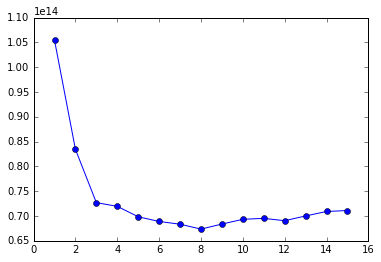

In [234]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')